In [270]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import pandas as pd
from sklearn.model_selection import train_test_split

In [402]:
class NeuralNetwork:

  # the weights are a matrix (can be seen as nested lists)
  # the first dimension is the amount of nodes in the previous layer
  # the second dimension is the amount of nodes in the next layer
  # the bias is a vector (like a single list) of zeros, which will be updated during backpropagation
  def __init__(self, input_size, hidden_size, output_size):
    # he initialization is used to initialise weights
    self.W_IH = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
    self.W_HO = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
    self.b_H = np.zeros(hidden_size)
    self.b_O = np.zeros(output_size)
  
  # the feedforward function calculates the output of the network
  # here, the hidden layer uses the relu activation function
  # the output layer uses the softmax activation function
  def feedforward(self, x):
    self.hidden_z = np.dot(x, self.W_IH) + self.b_H
    self.hidden_activation = self.relu(self.hidden_z)

    self.output_z = np.dot(self.hidden_activation, self.W_HO) + self.b_O
    self.output_activation = self.softmax(self.output_z)
    return self.output_activation
  
  # the cost function used is the cross-entropy loss
  # this basically calculates how accurate the prediction is
  def cost(self, y_hat, y, deriv=False):
    if deriv:
        return y_hat - y 
    y_hat = np.clip(y_hat, 1e-15, 1. - 1e-15)
    return -np.mean(np.sum(y * np.log(y_hat), axis=-1))

  
  # the relu activation function is used for the hidden layer
  # it can basically be seen as returning 0 if negative, and the value if positive
  def relu(self, x, deriv=False):
    if deriv:
        return (x > 0).astype(float)
    return np.maximum(0, x)
    
  # the softmax activation function is used for the output layer
  # it calculates the probability of each class, where the highest probability is the prediction
  def softmax(self, x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

  
  # the backpropagation function calculates the error of the prediction
  # and updates the weights and biases
  # simply explained, using the chain rule it's able to see what direction to update the weights
  # the learning rate is used to determine how much the weights should be updated
  def backpropagation(self, x, y_hat, y, learning_rate):
    Eo = self.cost(y_hat, y, deriv=True)
    Eh = np.dot(Eo, self.W_HO.T) * self.relu(self.hidden_z, True)

    self.W_IH -= learning_rate * np.dot(x.T, Eh)
    self.b_H -= learning_rate * np.sum(Eh, axis=0)
    self.W_HO -= learning_rate * np.dot(self.hidden_activation.T, Eo)
    self.b_O -= learning_rate * np.sum(Eo, axis=0)

  def train_bgd(self, x, y, epochs, learning_rate):
    loss = []
    accuracy = []
    for epoch in range(epochs):
      y_hat = self.feedforward(x)
      self.backpropagation(x, y_hat, y, learning_rate)
      loss.append(self.cost(y_hat, y))
      predictions = np.argmax(y_hat, axis=1)
      targets = np.argmax(y, axis=1)
      acc = np.mean(predictions == targets) * 100
      accuracy.append(acc)
      print(f'Epoch: {epoch+1}/{epochs}, Loss: {loss[-1]}, Accuracy: {accuracy}')

    return loss, accuracy
  
  def train_mbgd(self, x, y, epochs, learning_rate, batch_size):
    loss = []
    accuracy = []
    n_samples = x.shape[0]
    
    for epoch in range(epochs):
      indices = np.arange(n_samples)
      np.random.shuffle(indices)
      x = x[indices]
      y = y[indices]
      
      for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        batch_x = x[start:end]
        batch_y = y[start:end]
        
        y_hat = self.feedforward(batch_x)
        self.backpropagation(batch_x, y_hat, batch_y, learning_rate)
      
      y_hat = self.feedforward(x)
      loss.append(self.cost(y_hat, y))
      predictions = np.argmax(y_hat, axis=1)
      targets = np.argmax(y, axis=1)
      acc = np.mean(predictions == targets) * 100
      accuracy.append(acc)
    return loss, accuracy
  
  def predict(self, x, y, epochs):
    output = self.feedforward(x)
    true_class = np.argmax(y, axis=1)
    predicted_class = np.argmax(output, axis=1)
    accuracy = np.mean(predicted_class == true_class) * 100 
    return accuracy, predicted_class, true_class

In [293]:
iris = load_iris()
train_x, test_x, train_y, test_y = train_test_split(iris['data'], iris['target'], test_size=0.2, random_state=42)
train_y = np.eye(3)[train_y]
test_y = np.eye(3)[test_y]

mnist_train = pd.read_csv('./mnist/mnist_train.csv', header=None)
mnist_test = pd.read_csv('./mnist/mnist_test.csv', header=None)

In [440]:
def render_mnist(data, predicted, true_number, amount_correct, amount_false):
  correct_indices = np.where(predicted == true_number)[0]
  false_indices = np.where(predicted != true_number)[0]

  fig, axes = plt.subplots(1, amount_correct, figsize=(15, 3))
  for idx, ax in zip(correct_indices[:amount_correct], axes):
    ax.imshow(data[idx].reshape(28, 28), cmap='gray')
    ax.set_title(f"Predicted: {predicted[idx]}, True: {true_number[idx]}")
    ax.axis('off')
  plt.suptitle('Predictions')
  plt.show()

  fig, axes = plt.subplots(1, amount_false, figsize=(15, 3))
  for idx, ax in zip(false_indices[:amount_false], axes):
    ax.imshow(data[idx].reshape(28, 28), cmap='gray')
    ax.set_title(f"Predicted: {predicted[idx]}, True: {true_number[idx]}")
    ax.axis('off')
  plt.suptitle('Incorrect Predictions')
  plt.show()


  

# IRIS dataset

input size: 4, hidden size: 7, output size: 3


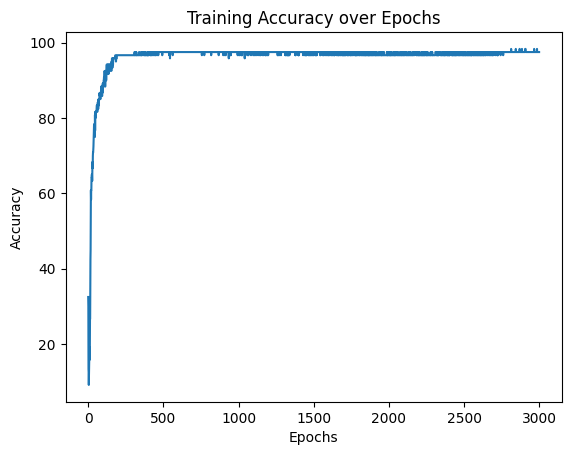

Average Training Accuracy: 97.54% ± 0.18%
Average Testing Accuracy: 97.67% ± 1.86%


In [ ]:
input_size = len(iris['data'][0])
output_size = len(np.unique(iris['target']))
hidden_size = 7
print(f"input size: {input_size}, hidden size: {hidden_size}, output size: {output_size}")

network = NeuralNetwork(input_size, hidden_size, output_size)
epochs = 3000
learning_rate = 0.0001

train_accuracies = []
test_accuracies = []

for i in range(20):
  loss, accuracy = network.train_mbgd(train_x, train_y, epochs, learning_rate, 5)
  train_accuracies.append(accuracy[-1])
  test_accuracy = network.predict(test_x, test_y, 50)
  test_accuracies.append(test_accuracy)
  if i == 0:
    plt.plot(accuracy)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy over Epochs')
    plt.show()

avg_train_accuracy = np.mean(train_accuracies)
std_train_accuracy = np.std(train_accuracies)
avg_test_accuracy = np.mean(test_accuracies)
std_test_accuracy = np.std(test_accuracies)

print(f"Average Training Accuracy: {avg_train_accuracy:.2f}% ± {std_train_accuracy:.2f}%")
print(f"Average Testing Accuracy: {avg_test_accuracy:.2f}% ± {std_test_accuracy:.2f}%")

# MNIST dataset

input size: 784, hidden size: 392, output size: 10
Test accuracy in % 98.35000000000001


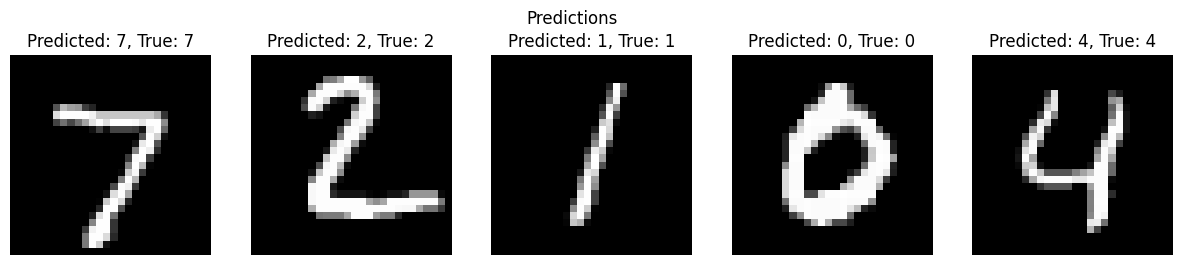

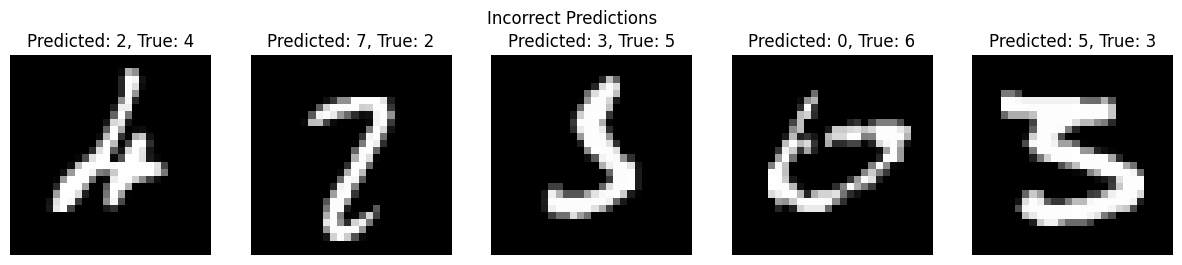

In [441]:
mnist_train_x = mnist_train.iloc[:, 1:].values / 255
mnist_train_y = np.eye(10)[mnist_train.iloc[:, 0].values]
mnist_test_x = mnist_test.iloc[:, 1:].values / 255
mnist_test_y = np.eye(10)[mnist_test.iloc[:, 0].values]

input_size = len(mnist_train_x[0])
output_size = len(np.unique(mnist_train.iloc[:, 0].values))
hidden_size = input_size // 2
print(f"input size: {input_size}, hidden size: {hidden_size}, output size: {output_size}")

network = NeuralNetwork(input_size, hidden_size, output_size)
epochs = 20
learning_rate = 0.01

loss, accuracy = network.train_mbgd(mnist_train_x, mnist_train_y, epochs, learning_rate, 64)
test_accuracy, predicted_class, true_class = network.predict(mnist_test_x, mnist_test_y, 2)
print(f"Test accuracy in % {test_accuracy}")
render_mnist(mnist_test_x, predicted_class, true_class, 5, 5)


